In [4]:
#Git clone the ddsp_textures repo in the parent directory if you haven't already
import os
import subprocess

# Define the path where you want to clone the repository
repo_url = "https://github.com/cordutie/ddsp_textures.git"
clone_path = os.path.abspath(os.path.join('..', '..', 'ddsp_textures'))

# Check if the directory already exists
if not os.path.exists(clone_path):
    print(f"Cloning the repository to {clone_path}...")
    subprocess.run(["git", "clone", repo_url, clone_path])
    print("Repository cloned successfully.")
else:
    print(f"The repository already exists at {clone_path}.")

The repository already exists at /home/esteban/Desktop/ddsp_textures_thesis/ddsp_textures.


In [5]:
#Add the ddsp's parent directory to the Python path so that we can import the necessary modules
import sys

ddsp_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if ddsp_dir not in sys.path:
    sys.path.append(ddsp_dir)

In [46]:
# import modules
from ddsp_textures.loss.functions import statistics_loss
import ddsp_textures.auxiliar.filterbanks as fb

# Extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch

def segmentation(audio_numpy, frame_size):
    audio_numpy_size = len(audio_numpy)
    segments_number = audio_numpy_size // frame_size
    segments_list = []
    for i in range(0,segments_number):
        segment_local = audio_numpy[i*frame_size:(i+1)*frame_size]
        segment_local_tensor = torch.tensor(segment_local, dtype=torch.float32)
        segments_list.append(segment_local_tensor)
    return segments_list

def loss_reporter(a, B, sr, N_filter_bank, erb_bank, log_bank):
    statistics_loss_list = []
    for b in B:
        statistics_loss_list.append(statistics_loss(a, b, N_filter_bank, sr, erb_bank, log_bank))
    #Compute the average and std of each loss. They are lists of tensors:
    statistics_loss_list = torch.stack(statistics_loss_list)
    statistics_loss_avg  = torch.mean(statistics_loss_list)
    return statistics_loss_avg

import random

# Create a subset of 100 random items
def separation_statistics_loss(audio_X, audio_Y, frame_size, sr, N_filter_bank):
    #for loss calculation
    erb_bank = fb.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
    new_size = frame_size // 4
    new_sample_rate = sr // 4
    log_bank = fb.Logarithmic(new_size, new_sample_rate, 6, 20, new_sample_rate // 2)
    
    segments_X = segmentation(audio_X, frame_size)
    segments_X = segments_X[:20]

    segments_Y = segmentation(audio_Y, frame_size)
    segments_Y = segments_Y[:20]
    print("segmentation done")
    
    j=1
    losses_x_Y = []
    losses_x_X = []
    for x in segments_X:
        result_local_x_Y = loss_reporter(x, segments_Y, sr, N_filter_bank, erb_bank, log_bank)
        print("distance x_Y",j,": ",result_local_x_Y)
        losses_x_Y.append(result_local_x_Y)
        result_local_x_X = loss_reporter(x, segments_X, sr, N_filter_bank, erb_bank, log_bank)
        print("distance x_X",j,": ",result_local_x_X)
        losses_x_X.append(result_local_x_X)
        j=j+1
    
    j=1
    losses_y_X = []
    losses_y_Y = []
    for y in segments_Y:
        result_local_y_X = loss_reporter(y, segments_X, sr, N_filter_bank, erb_bank, log_bank)
        losses_y_X.append(result_local_y_X)
        print("distance y_X",j,": ",result_local_y_X)
        result_local_y_Y = loss_reporter(y, segments_Y, sr, N_filter_bank, erb_bank, log_bank)
        print("distance y_Y",j,": ",result_local_y_Y)
        losses_y_Y.append(result_local_y_Y)
        j=j+1
        
    return np.array(losses_x_Y), np.array(losses_y_X), np.array(losses_x_X), np.array(losses_y_Y)

In [47]:
# Load audio to resynthesize ----------------------------
fire_path = "../data/sounds/fire.wav"
label = "Fire"
sr         = 44100
frame_size = 2**17
fire_audio, _ = librosa.load(fire_path, sr=sr)
fire_audio = librosa.util.normalize(fire_audio)
fire_audio = librosa.effects.preemphasis(fire_audio)

water_path = "../data/sounds/water.wav"
label = "Water"
sr         = 44100
frame_size = 2**17
water_audio, _ = librosa.load(water_path, sr=sr)
water_audio = librosa.util.normalize(water_audio)

min_size = min(len(fire_audio), len(water_audio))
fire_audio  = fire_audio[:min_size]
water_audio = water_audio[:min_size]

loss_fire_WATER, loss_water_FIRE, loss_water_fire_FIRE, loss_water_WATER = separation_statistics_loss(fire_audio, water_audio, frame_size, sr, 24)


segmentation done
distance x_Y 1 :  tensor(1.2191)
distance x_X 1 :  tensor(0.8155)
distance x_Y 2 :  tensor(0.8674)
distance x_X 2 :  tensor(0.6563)
distance x_Y 3 :  tensor(1.0135)
distance x_X 3 :  tensor(0.7048)
distance x_Y 4 :  tensor(0.9759)
distance x_X 4 :  tensor(0.6948)
distance x_Y 5 :  tensor(0.7265)
distance x_X 5 :  tensor(0.7064)
distance x_Y 6 :  tensor(0.7275)
distance x_X 6 :  tensor(0.6881)
distance x_Y 7 :  tensor(0.7729)
distance x_X 7 :  tensor(0.6937)
distance x_Y 8 :  tensor(0.7627)
distance x_X 8 :  tensor(0.6811)
distance x_Y 9 :  tensor(1.1503)
distance x_X 9 :  tensor(0.7700)
distance x_Y 10 :  tensor(1.0780)
distance x_X 10 :  tensor(0.7159)
distance x_Y 11 :  tensor(0.7887)
distance x_X 11 :  tensor(0.6784)
distance x_Y 12 :  tensor(0.9281)
distance x_X 12 :  tensor(0.6652)
distance x_Y 13 :  tensor(0.7489)
distance x_X 13 :  tensor(0.6884)
distance x_Y 14 :  tensor(0.8624)
distance x_X 14 :  tensor(0.6629)
distance x_Y 15 :  tensor(0.8811)
distance x_X 1

In [49]:
# save the numpy arrays losses as np save
np.save("loss_fire_WATER.npy", loss_fire_WATER)
np.save("loss_water_FIRE.npy", loss_water_FIRE)
np.save("loss_fire_FIRE.npy", loss_water_fire_FIRE)
np.save("loss_water_WATER.npy", loss_water_WATER)


In [53]:
#load the losses
loss_fire_WATER = np.load("loss_fire_WATER.npy")
loss_water_FIRE = np.load("loss_water_FIRE.npy")
loss_fire_FIRE = np.load("loss_fire_FIRE.npy")
loss_water_WATER = np.load("loss_water_WATER.npy")

# def transform(x):
#     return 2**((((np.log2(x)+1)*9)/3)-1)

# #apply the transform for all losses
# loss_fire_WATER = transform(loss_fire_WATER)
# loss_water_FIRE = transform(loss_water_FIRE)
# loss_fire_FIRE = transform(loss_fire_FIRE)
# loss_water_WATER = transform(loss_water_WATER)

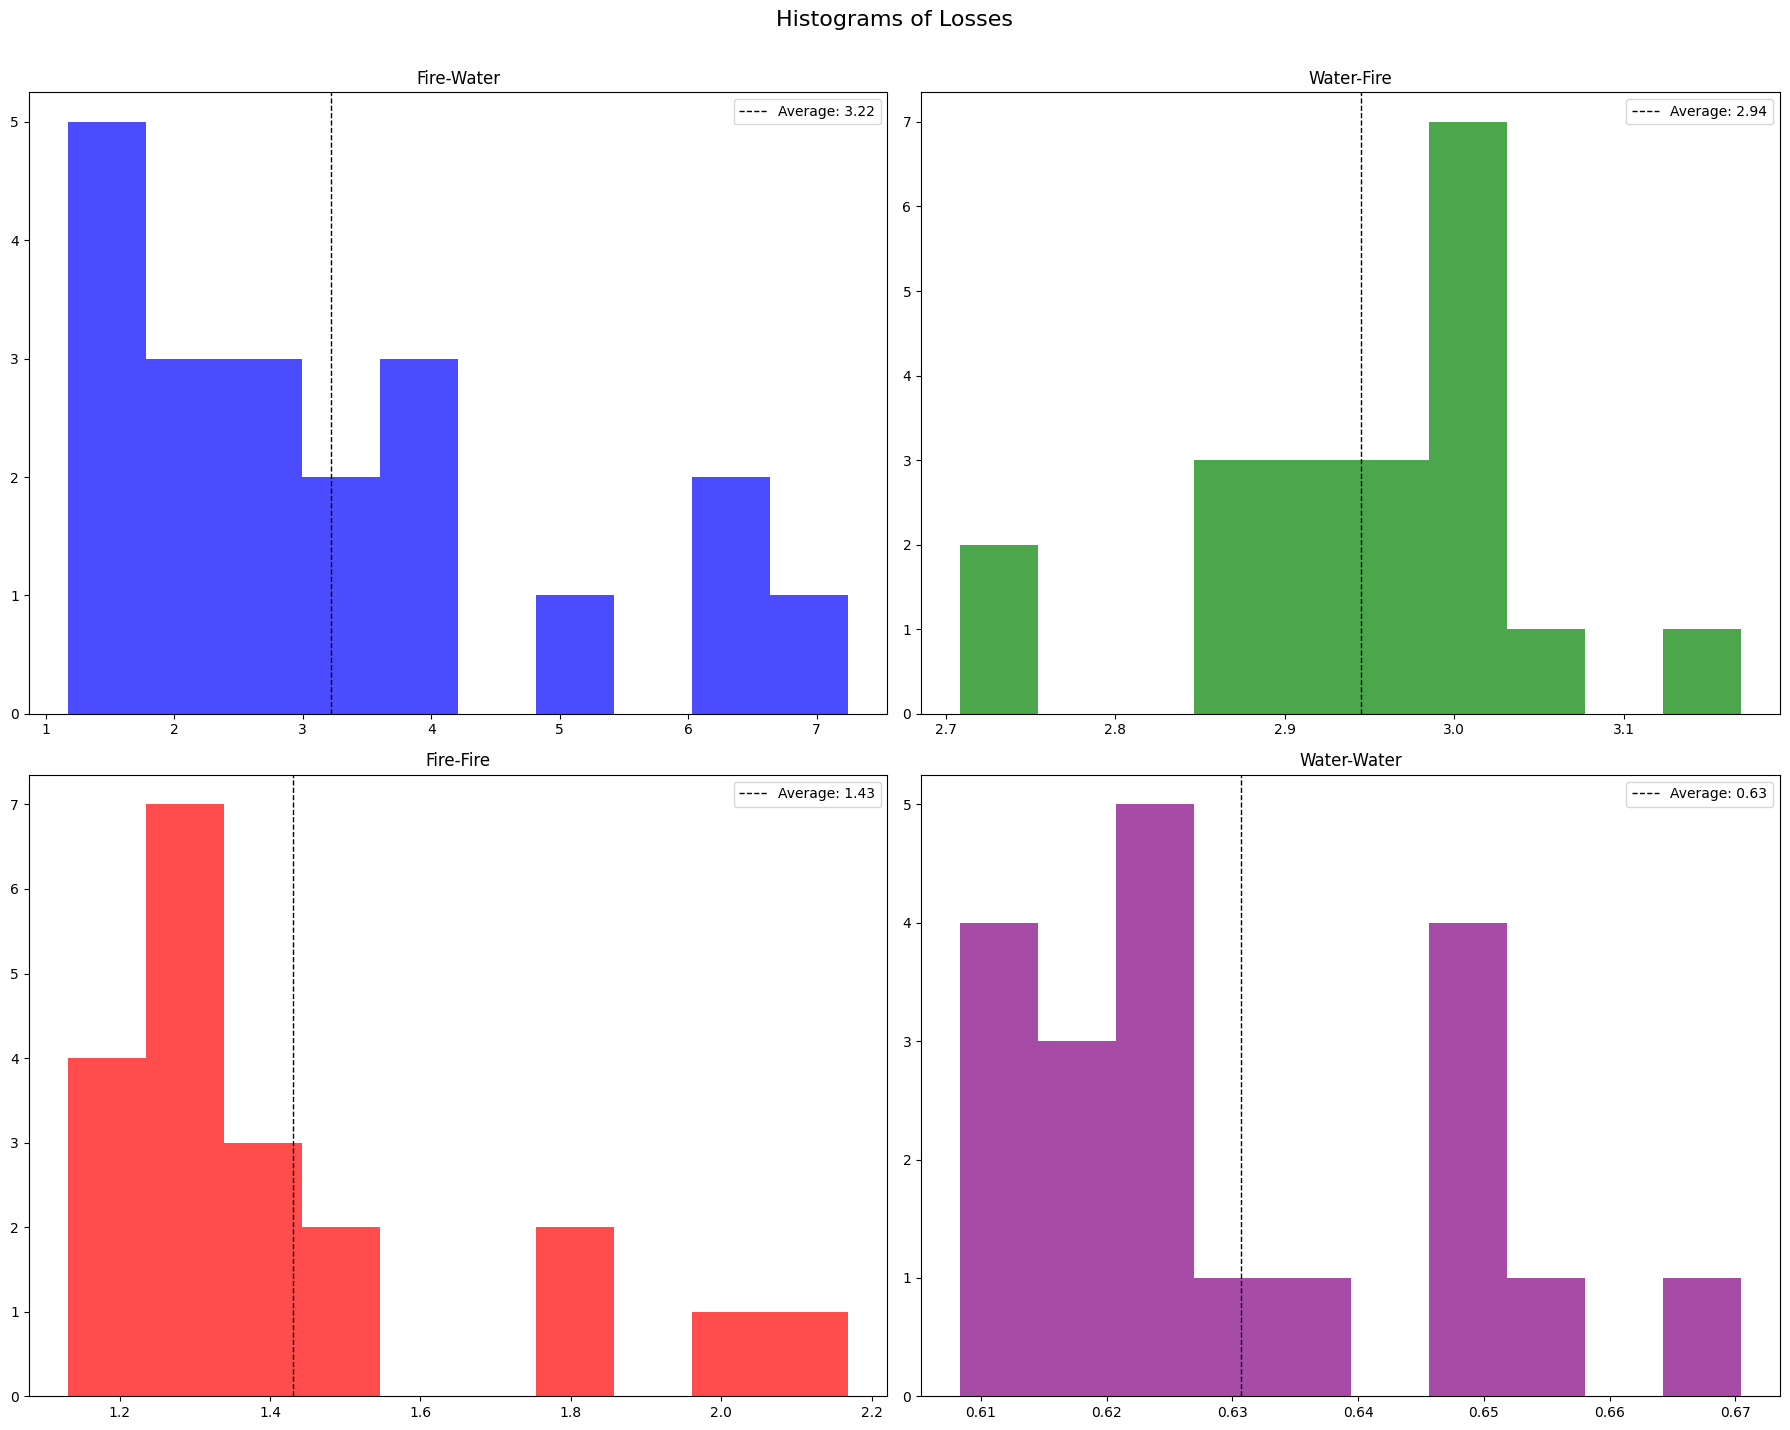

In [62]:
import matplotlib.pyplot as plt

# Define the number of bins and colors for each histogram
bins = 10
colors = ['blue', 'green', 'red', 'purple']

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12*1.5, 10*1.5))

# Plot the histograms with legends showing the average
axs[0, 0].hist(loss_fire_WATER, bins=bins, alpha=0.7, color=colors[0])
mean_fire_WATER = loss_fire_WATER.mean()
axs[0, 0].axvline(mean_fire_WATER, color='k', linestyle='dashed', linewidth=1)
axs[0, 0].legend([f'Average: {mean_fire_WATER:.2f}'])
axs[0, 0].set_title('Fire-Water')

axs[0, 1].hist(loss_water_FIRE, bins=bins, alpha=0.7, color=colors[1])
mean_water_FIRE = loss_water_FIRE.mean()
axs[0, 1].axvline(mean_water_FIRE, color='k', linestyle='dashed', linewidth=1)
axs[0, 1].legend([f'Average: {mean_water_FIRE:.2f}'])
axs[0, 1].set_title('Water-Fire')

axs[1, 0].hist(loss_fire_FIRE, bins=bins, alpha=0.7, color=colors[2])
mean_fire_FIRE = loss_fire_FIRE.mean()
axs[1, 0].axvline(mean_fire_FIRE, color='k', linestyle='dashed', linewidth=1)
axs[1, 0].legend([f'Average: {mean_fire_FIRE:.2f}'])
axs[1, 0].set_title('Fire-Fire')

axs[1, 1].hist(loss_water_WATER, bins=bins, alpha=0.7, color=colors[3])
mean_water_WATER = loss_water_WATER.mean()
axs[1, 1].axvline(mean_water_WATER, color='k', linestyle='dashed', linewidth=1)
axs[1, 1].legend([f'Average: {mean_water_WATER:.2f}'])
axs[1, 1].set_title('Water-Water')

# Adjust the layout and add a common title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Histograms of Losses', fontsize=16)
plt.show()
